In [20]:
%matplotlib inline

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 400

In [22]:
#Importing the dataset
df = pd.read_csv('messages.csv')
df.head(10)

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   
5  call for abstracts : optimality in syntactic t...   
6                m . a . in scandinavian linguistics   
7  call for papers : linguistics session of the m...   
8                    foreign language in commercials   
9  fulbright announcement : please post / dissemi...   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
1  lang classification grimes , joseph e . and ba...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0  
5  content - length : 4437 call for papers is the...      0  
6  m . a . in scandinavian linguistics at the uni...      0  
7  call for papers linguistics session - - midwes...      0  
8  content - length : 1937 greetings ! i ' m wond...      0  
9  fulbright announcement : please post / dissemi...      0

<AxesSubplot:xlabel='label', ylabel='count'>

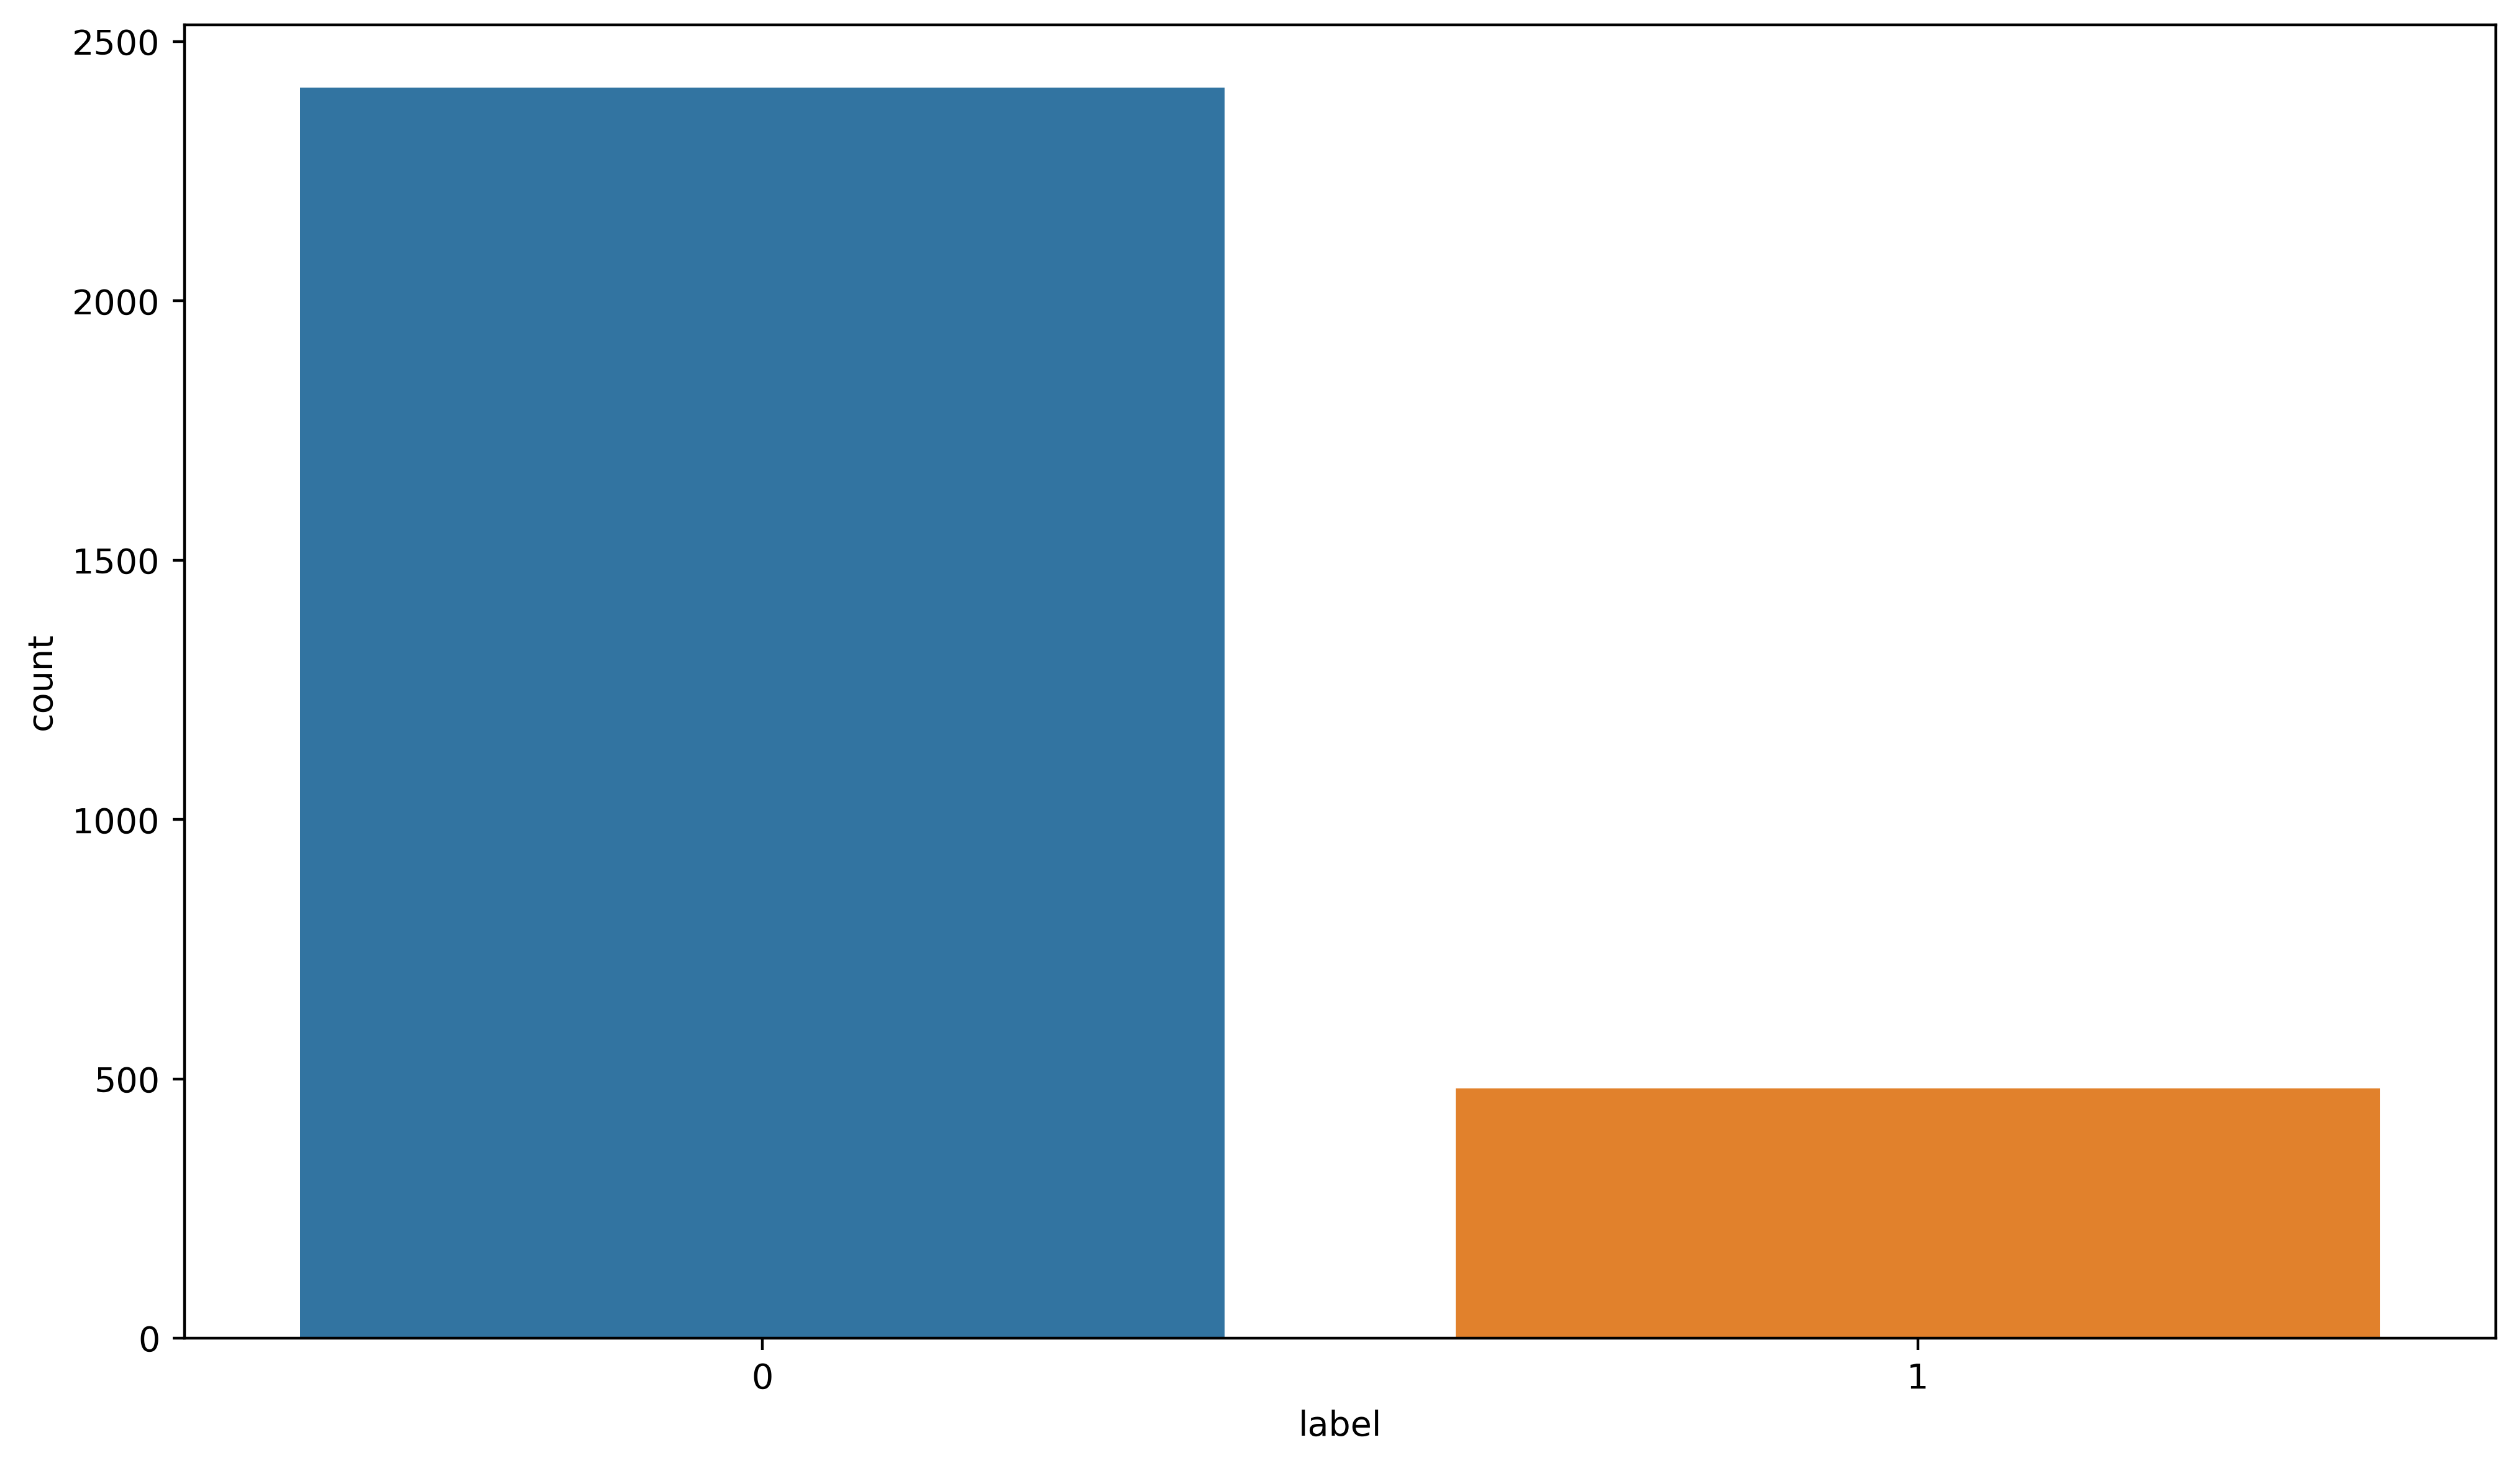

In [23]:
import seaborn as sns
plt.figure().set_size_inches(12,7)
sns.countplot(data = df, x = 'label')

Clearly an imbalanced dataset

In [24]:
df.shape

(2893, 3)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [26]:
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

We will be using the email body to predict the Spam/No-spam classification

In [27]:
#Dropping the subject column
df.drop('subject', axis = 1, inplace = True)

In [28]:
df.head()

message  label
0  content - length : 3386 apple-iss research cen...      0
1  lang classification grimes , joseph e . and ba...      0
2  i am posting this inquiry for sergei atamas ( ...      0
3  a colleague and i are researching the differin...      0
4  earlier this morning i was on the phone with a...      0

In [29]:
#Splitting into train_test split
from sklearn.model_selection import train_test_split
X = df['message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10)

In [30]:
print(X_train.shape)
print(X_test.shape)

(2169,)
(724,)


## Approach 1 : Bag of Words, ngram = 3, mid_df = 3

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

#Vectorizing the text corpus
vect = CountVectorizer(min_df = 5, ngram_range = (1,3)).fit(X_train)

#Extracting the Vocabulary
vocab = vect.get_feature_names()
print('Length of Vocabulary: ', len(vocab))


Length of Vocabulary:  52679


In [32]:
X_train_tr = vect.transform(X_train)
X_test_tr = vect.transform(X_test)

In [33]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
lr_clf = LogisticRegression().fit(X_train_tr, y_train)
y_pred = lr_clf.predict(X_test_tr)

def metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('ROC_AUC score: )', roc_auc_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

metrics(y_test,y_pred)

Accuracy:  0.9848066298342542
F1 score:  0.9527896995708154
ROC_AUC score: ) 0.9608443708609272
[[602   2]
 [  9 111]]


We are getting good results from Logistic regression

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       604
           1       0.98      0.93      0.95       120

    accuracy                           0.98       724
   macro avg       0.98      0.96      0.97       724
weighted avg       0.98      0.98      0.98       724



In [35]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb_clf = MultinomialNB(alpha=0.1).fit(X_train_tr, y_train)

y_pred = mnb_clf.predict(X_test_tr)

metrics(y_test, y_pred)


Accuracy:  0.9917127071823204
F1 score:  0.9747899159663865
ROC_AUC score: ) 0.9816777041942605
[[602   2]
 [  4 116]]


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       604
           1       0.98      0.97      0.97       120

    accuracy                           0.99       724
   macro avg       0.99      0.98      0.98       724
weighted avg       0.99      0.99      0.99       724



Improvement over the logistic regression model

In [37]:
#SVM 
from sklearn.svm import SVC
svc_clf = SVC().fit(X_train_tr, y_train)

y_pred = svc_clf.predict(X_test_tr)

metrics(y_test, y_pred)

Accuracy:  0.93646408839779
F1 score:  0.7628865979381444
ROC_AUC score: ) 0.8083333333333333
[[604   0]
 [ 46  74]]


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       604
           1       1.00      0.62      0.76       120

    accuracy                           0.94       724
   macro avg       0.96      0.81      0.86       724
weighted avg       0.94      0.94      0.93       724



The model is unable to classify the spam mails, the precision is very high, but recall is low.

## Approach 2: TFIDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 5, ngram_range = (1,3)).fit(X_train)
vocab = tfidf.get_feature_names()
print('Length of Vocabulary: ', len(vocab))

Length of Vocabulary:  52679


In [40]:
#Transforming the data
X_train_tr = tfidf.transform(X_train)
X_test_tr = tfidf.transform(X_test)

In [41]:
#Logistic regression
lr_clf = LogisticRegression().fit(X_train_tr, y_train)
y_pred = lr_clf.predict(X_test_tr)
metrics(y_test,y_pred)

Accuracy:  0.9654696132596685
F1 score:  0.8837209302325582
ROC_AUC score: ) 0.8958333333333333
[[604   0]
 [ 25  95]]


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       604
           1       1.00      0.79      0.88       120

    accuracy                           0.97       724
   macro avg       0.98      0.90      0.93       724
weighted avg       0.97      0.97      0.96       724



In [43]:
#Naive Bayes
mnb_clf = MultinomialNB(alpha=0.1).fit(X_train_tr, y_train)

y_pred = mnb_clf.predict(X_test_tr)

metrics(y_test, y_pred)

Accuracy:  0.9903314917127072
F1 score:  0.9702127659574469
ROC_AUC score: ) 0.9741721854304637
[[603   1]
 [  6 114]]


In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       604
           1       0.99      0.95      0.97       120

    accuracy                           0.99       724
   macro avg       0.99      0.97      0.98       724
weighted avg       0.99      0.99      0.99       724



In [45]:
#SVC
svc_clf = SVC().fit(X_train_tr, y_train)

y_pred = svc_clf.predict(X_test_tr)

metrics(y_test, y_pred)

Accuracy:  0.9806629834254144
F1 score:  0.9380530973451328
ROC_AUC score: ) 0.9416666666666667
[[604   0]
 [ 14 106]]


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       604
           1       1.00      0.88      0.94       120

    accuracy                           0.98       724
   macro avg       0.99      0.94      0.96       724
weighted avg       0.98      0.98      0.98       724



In [47]:
#Lets take a look at words that have Large/small tfidf

In [48]:
feat = tfidf.get_feature_names()
idf = tfidf.idf_
 
df_ = pd.DataFrame({'Features': feat, 'idf': idf})

In [49]:
l_idf = df_.sort_values(by = 'idf', ascending = False).head(20)
s_idf = df_.sort_values(by = 'idf', ascending = True).head(20)

In [50]:
l_idf

Features       idf
34579                     place where  6.890723
34538                         pioneer  6.890723
8406                      before june  6.890723
8407                 before licencing  6.890723
8408              before licencing it  6.890723
22268           information esslli 98  6.890723
34725              please make checks  6.890723
8412                        before or  6.890723
34722                     please look  6.890723
22272  information extraction systems  6.890723
8415                       before she  6.890723
34717             please indicate the  6.890723
34711                     please help  6.890723
14351                      dominating  6.890723
22277             information for the  6.890723
34697                   please excuse  6.890723
22279        information from corpora  6.890723
22280            information from the  6.890723
14347                  domains use of  6.890723
34682               please contact dr  6.890723

In [51]:
s_idf

Features       idf
42600      the  1.047662
30095       of  1.059329
4286       and  1.090116
46146       to  1.105873
21051       in  1.116689
17175      for  1.162248
23029       is  1.258914
31797       on  1.264902
7789        be  1.321107
31259   of the  1.405926
32450       or  1.429012
6214       are  1.431137
45449     this  1.454094
50952     with  1.467242
7093        at  1.469451
9503        by  1.503937
21699   in the  1.528649
6711        as  1.536498
18185     from  1.536498
42283     that  1.589078

SO the words which are repeated frequently in every document have small idf

The words which are rare can have more predictive value, so they have larger idf